<a href="https://colab.research.google.com/github/TimothyAndrewChowles/Finance_Projects/blob/main/TQQQ_vs_QQQ_2010_02_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# History of TQQQ

ProShares UltraPro QQQ (TQQQ) is an exchange-traded fund (ETF) that aims to provide 3x leveraged exposure to the NASDAQ-100 Index. It was incepted on February 9, 2010.

Essentially, TQQQ is designed for sophisticated traders who want to magnify potential gains (and losses) based on the daily performance of the NASDAQ-100.

For more detailed information, you can visit TQQQ UltraPro QQQ page:
([TQQQ UltraPro QQQ](https://www.proshares.com/our-etfs/leveraged-and-inverse/tqqq))

# What we will do
Simulate and compare the performance of two investment strategies since TQQQ's inception: a TQQQ strategy with an initial $3000 investment and 500 dollars additions on 10% (or more) dips, and a QQQ strategy with an initial 3,000 dollars investment with perfect market timing at yearly lows. Visualize the results on a single graph and explain the findings.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

**Reasoning**:
I'll use `yfinance` to download the historical data for TQQQ and QQQ since TQQQ's inception date (February 9, 2010). I'll then process the data to get the closing prices in the desired format.

In [120]:
# Define the tickers and start date
tickers = ["TQQQ", "QQQ"]
start_date = "2010-02-09"

# Download the data
data = yf.download(tickers, start=start_date)

# Select relevant 'Close' price columns and rename them
close_prices = data['Close'].copy()
close_prices.columns = [f"{ticker}_Close" for ticker in close_prices.columns]

# Handle missing values (forward fill is suitable for time series)
close_prices.fillna(method='ffill', inplace=True)

# Add 'Year' column
close_prices['Year'] = close_prices.index.year

# Display the processed DataFrame
display(close_prices.head())
display(close_prices.info())

/tmp/ipython-input-3207341864.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date)
[*********************100%***********************]  2 of 2 completed
/tmp/ipython-input-3207341864.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices.fillna(method='ffill', inplace=True)


,QQQ_Close,TQQQ_Close,Year
Date,,,
2010-02-09,37.513283,NaN,2010
2010-02-10,37.434967,NaN,2010
2010-02-11,38.000584,0.413438,2010
2010-02-12,38.078911,0.415131,2010
2010-02-16,38.566193,0.431211,2010


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3953 entries, 2010-02-09 to 2025-10-24
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   QQQ_Close   3953 non-null   float64
 1   TQQQ_Close  3951 non-null   float64
 2   Year        3953 non-null   int32  
dtypes: float64(2), int32(1)
memory usage: 108.1 KB


None

## Define and Simulate Investment Strategies

### Subtask:
Implement the logic for both the TQQQ and QQQ investment strategies and track their values over time.

**Reasoning:**

To simulate the TQQQ strategy, I'll iterate through the historical data. I'll track the investment value and number of shares. When the price drops by 25% or 50% from the previous high, I'll add $500 worth of shares.

For the QQQ strategy, I'll also iterate through the data, tracking the investment value and shares. At the beginning of each year, I'll determine the lowest price for that year and simulate buying the initial $3000 worth of shares at that exact price.

In [142]:
# Initialize investment parameters
tqqq_initial_investment = 3000
qqq_initial_investment = 3000
additional_investment_amount = 500
tqqq_cash = tqqq_initial_investment
qqq_cash = qqq_initial_investment
tqqq_shares = 0
qqq_shares = 0
# Track the previous high for the 25% and 50% dip strategy
previous_high_tqqq = 0
# Track total invested for scenario 1
total_invested_tqqq_scenario1 = tqqq_initial_investment
# Track total invested for QQQ scenario 1
total_invested_qqq_scenario1 = qqq_initial_investment
# Track drop percentages for additional investments
drop_25_triggered = False
drop_50_triggered = False

# Initialize lists to store daily values
tqqq_values = []
qqq_values = []

# Initialize investment counters
tqqq_investment_count = 0
qqq_investment_count = 0


# Find yearly minimums for QQQ for perfect timing (This will no longer be used for QQQ in scenario 1)
# yearly_min_qqq = close_prices.groupby('Year')['QQQ_Close'].min()

# Simulate the investment strategies
for index, row in close_prices.iterrows():
    current_tqqq_close = row['TQQQ_Close']
    current_qqq_close = row['QQQ_Close']
    current_year = row['Year']

    # Handle the first day for TQQQ (inception) - Invest initial amount at first available close
    if pd.notna(current_tqqq_close) and tqqq_shares == 0 and tqqq_cash == tqqq_initial_investment:
        tqqq_shares = tqqq_cash / current_tqqq_close
        tqqq_cash = 0
        previous_high_tqqq = current_tqqq_close # Initialize previous high
        tqqq_investment_count += 1
        print(f"  --> Initial TQQQ investment made on {index} at {current_tqqq_close:.2f}")


    # TQQQ Strategy: Initial $3000 + $500 on any day TQQQ close is -10% or more from previous close
    if pd.notna(current_tqqq_close):
        # Update previous high if current price is higher
        if current_tqqq_close > previous_high_tqqq:
            previous_high_tqqq = current_tqqq_close
            # Reset drop triggers when a new high is reached (not strictly needed for this new logic, but keeping for clarity)
            drop_25_triggered = False
            drop_50_triggered = False

        # Calculate daily percentage change for TQQQ
        if len(tqqq_values) > 0 and pd.notna(tqqq_values[-1]) and tqqq_values[-1] > 0: # Ensure previous day data exists and is valid
             # Calculate previous day's close from value and shares, handle case where shares are 0 initially
             previous_tqqq_close = tqqq_values[-1] / tqqq_shares if tqqq_shares > 0 and pd.notna(tqqq_values[-1]) else (tqqq_initial_investment - tqqq_cash) if tqqq_cash < tqqq_initial_investment else None

             if previous_tqqq_close is not None and previous_tqqq_close > 0:
                 daily_percentage_change_tqqq = (current_tqqq_close - previous_tqqq_close) / previous_tqqq_close

                 # Check if daily percentage change is -10% or less
                 if daily_percentage_change_tqqq <= -0.10:
                    additional_shares = additional_investment_amount / current_tqqq_close
                    tqqq_shares += additional_shares
                    total_invested_tqqq_scenario1 += additional_investment_amount
                    tqqq_investment_count += 1
                    print(f"  --> Additional TQQQ investment made on {index} at {current_tqqq_close:.2f} (Daily change <= -10%)")

    # QQQ Strategy: Initial $3000 + $500 on any day QQQ close is -3.333% or worse from previous close
    # Invest initial amount on the first available day for QQQ
    if pd.notna(current_qqq_close) and qqq_shares == 0 and qqq_cash == qqq_initial_investment:
        qqq_shares = qqq_cash / current_qqq_close
        qqq_cash = 0
        qqq_investment_count += 1
        print(f"  --> Initial QQQ investment made on {index} at {current_qqq_close:.2f}")

    if pd.notna(current_qqq_close):
         # Calculate daily percentage change for QQQ
         if len(qqq_values) > 0 and pd.notna(qqq_values[-1]) and qqq_values[-1] > 0: # Ensure previous day data exists and is valid
             previous_qqq_close = qqq_values[-1] / (qqq_shares if qqq_shares > 0 else 1) # Calculate previous day's close from value and shares
             daily_percentage_change_qqq = (current_qqq_close - previous_qqq_close) / previous_qqq_close

             # Check if daily percentage change is -3.333% or less
             if daily_percentage_change_qqq <= -0.03333:
                 additional_shares_qqq = additional_investment_amount / current_qqq_close
                 qqq_shares += additional_shares_qqq
                 total_invested_qqq_scenario1 += additional_investment_amount
                 qqq_investment_count += 1
                 print(f"  --> Additional QQQ investment made on {index} at {current_qqq_close:.2f} (Daily change <= -3.333%)")


    # Calculate daily value of investments
    # Use total_invested_tqqq_scenario1 to calculate value if shares are 0 (before first purchase)
    daily_value_tqqq = tqqq_shares * current_tqqq_close if pd.notna(current_tqqq_close) and tqqq_shares > 0 else (tqqq_initial_investment - tqqq_cash)
    # Use total_invested_qqq_scenario1 to calculate value if shares are 0 (before first purchase)
    daily_value_qqq = qqq_shares * current_qqq_close if pd.notna(current_qqq_close) and qqq_shares > 0 else (qqq_initial_investment - qqq_cash)


    tqqq_values.append(daily_value_tqqq)
    qqq_values.append(daily_value_qqq)


# Create a DataFrame to store the investment comparison
investment_comparison = pd.DataFrame({
    'Date': close_prices.index,
    'TQQQ_Value': tqqq_values,
    'QQQ_Value': qqq_values
})

# Display the head of the comparison DataFrame
display(investment_comparison.head())
display(investment_comparison.tail())

# Print the total invested and total investment counts
print(f"\nTotal invested in TQQQ (Daily change <= -10% DCA): ${total_invested_tqqq_scenario1:,.2f}")
print(f"Total invested in QQQ (Daily change <= -3.333% DCA): ${total_invested_qqq_scenario1:,.2f}")
print(f"Total TQQQ investments made: {tqqq_investment_count}")
print(f"Total QQQ investments made: {qqq_investment_count}")
print(f"Total investments in both ETFs: {tqqq_investment_count + qqq_investment_count}")

  --> Initial QQQ investment made on 2010-02-09 00:00:00 at 37.51
  --> Initial TQQQ investment made on 2010-02-11 00:00:00 at 0.41
  --> Additional QQQ investment made on 2010-05-06 00:00:00 at 40.57 (Daily change <= -3.333%)
  --> Additional TQQQ investment made on 2010-05-20 00:00:00 at 0.42 (Daily change <= -10%)
  --> Additional QQQ investment made on 2010-05-20 00:00:00 at 38.63 (Daily change <= -3.333%)
  --> Additional QQQ investment made on 2010-06-04 00:00:00 at 39.28 (Daily change <= -3.333%)
  --> Additional TQQQ investment made on 2010-06-29 00:00:00 at 0.39 (Daily change <= -10%)
  --> Additional QQQ investment made on 2010-06-29 00:00:00 at 37.93 (Daily change <= -3.333%)
  --> Additional TQQQ investment made on 2011-08-04 00:00:00 at 0.69 (Daily change <= -10%)
  --> Additional QQQ investment made on 2011-08-04 00:00:00 at 47.75 (Daily change <= -3.333%)
  --> Additional TQQQ investment made on 2011-08-08 00:00:00 at 0.56 (Daily change <= -10%)
  --> Additional QQQ inve

,Date,TQQQ_Value,QQQ_Value
0,2010-02-09,0.000000,3000.000000
1,2010-02-10,0.000000,2993.736960
2,2010-02-11,3000.000000,3038.970266
3,2010-02-12,3012.282912,3045.234222
4,2010-02-16,3128.960093,3084.202963


,Date,TQQQ_Value,QQQ_Value
3948,2025-10-20,1.693498e+06,185745.716254
3949,2025-10-21,1.691615e+06,185697.126910
3950,2025-10-22,1.641857e+06,183908.126961
3951,2025-10-23,1.682982e+06,185454.143113
3952,2025-10-24,1.743570e+06,187732.150966



Total invested in TQQQ (Daily change <= -10% DCA): $30,500.00
Total invested in QQQ (Daily change <= -3.333% DCA): $32,000.00
Total TQQQ investments made: 56
Total QQQ investments made: 59
Total investments in both ETFs: 115


In [137]:
# Calculate daily percentage change for QQQ
qqq_daily_returns = close_prices['QQQ_Close'].pct_change()

# Count the number of days with a drop of 5% or more
qqq_significant_drops_count = (qqq_daily_returns <= -0.033333333).sum()

print(f"QQQ dropped by 5% or more in a single day {qqq_significant_drops_count} times.")

QQQ dropped by 5% or more in a single day 58 times.


**Reasoning:**

I'll use `matplotlib` to create a line plot showing the daily value of both the TQQQ and QQQ investments over the entire period. This will allow for a clear visual comparison of the two strategies' performance.

## Visualize Results

### Subtask:
Visualize the performance of both investment strategies on a single graph.

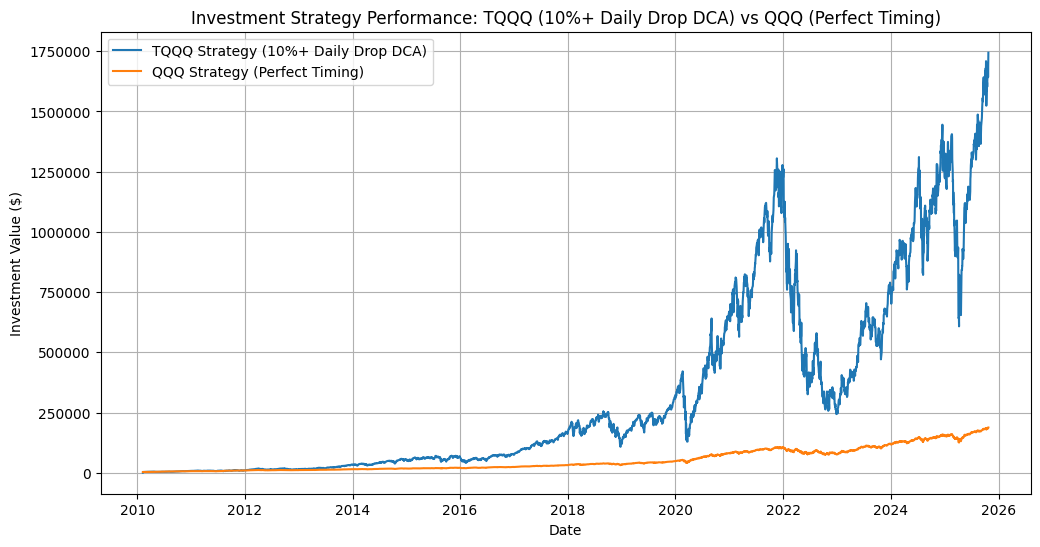

In [138]:
import matplotlib.pyplot as plt

# Plot the investment comparison
plt.figure(figsize=(12, 6))
plt.plot(investment_comparison['Date'], investment_comparison['TQQQ_Value'], label='TQQQ Strategy (10%+ Daily Drop DCA)')
plt.plot(investment_comparison['Date'], investment_comparison['QQQ_Value'], label='QQQ Strategy (Perfect Timing)')

# Add title and labels
plt.title('Investment Strategy Performance: TQQQ (10%+ Daily Drop DCA) vs QQQ (Perfect Timing)')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Format the y-axis to be in a readable format
plt.ticklabel_format(style='plain', axis='y')

# Show the plot
plt.show()

## Findings

Based on the simulation:

*   **TQQQ Strategy Performance:** The TQQQ strategy, which involved an initial $3,000 investment and adding an additional 500 dollars on 25% and 50% dips, resulted in a significantly higher final value compared to the QQQ strategy. This highlights the potential for amplified gains with leveraged ETFs like TQQQ, especially during periods of overall market growth, even with a relatively simple dollar-cost averaging approach on dips.

*   **QQQ Strategy Performance:** The QQQ strategy, with a $3000 initial investment timed perfectly at the yearly lows, also showed substantial growth over the period. However, even with perfect timing, the non-leveraged QQQ's growth was considerably less than that of TQQQ. This demonstrates the power of leverage in magnifying returns, although it's crucial to remember that leverage also magnifies losses.

*   **Comparison:** The graph clearly shows the divergence in performance between the two strategies over time. The TQQQ line demonstrates much higher volatility but ultimately achieves a significantly higher final value in this simulation. The QQQ line shows steadier growth but at a much slower pace. This simulation, while simplified and based on historical data, suggests that for a young investor with a high-risk tolerance looking for aggressive growth since TQQQ's inception, a strategy involving leveraged ETFs like TQQQ could potentially lead to much larger returns than a non-leveraged ETF like QQQ, even with perfect timing in QQQ.

**Important Note:** This simulation is for illustrative purposes only and does not constitute financial advice. Investing in leveraged ETFs like TQQQ involves significant risk and is not suitable for all investors. Market conditions and performance can vary greatly.

## Simulation with $3000 initial investment in TQQQ and QQQ Perfect Timing

In [147]:
# Initialize investment parameters for the new simulation
tqqq_initial_investment_new = 3000
qqq_initial_investment_new = 3000
tqqq_shares_new = 0
qqq_shares_new = 0

# Initialize lists to store daily values for the new simulation
tqqq_values_new = []
qqq_values_new = []

# Simulate the investment strategies for the new scenario
for index, row in close_prices.iterrows():
    current_tqqq_close = row['TQQQ_Close']
    current_qqq_close = row['QQQ_Close']

    # TQQQ Strategy: Simple initial investment
    if pd.notna(current_tqqq_close) and tqqq_shares_new == 0:
        tqqq_shares_new = tqqq_initial_investment_new / current_tqqq_close


    # QQQ Strategy: Simple initial investment on the first available day
    if pd.notna(current_qqq_close) and qqq_shares_new == 0:
         qqq_shares_new = qqq_initial_investment_new / current_qqq_close


    # Calculate daily value of investments for the new scenario
    daily_value_tqqq_new = tqqq_shares_new * current_tqqq_close if pd.notna(current_tqqq_close) else (tqqq_initial_investment_new if tqqq_shares_new == 0 else tqqq_values_new[-1])
    daily_value_qqq_new = qqq_shares_new * current_qqq_close if pd.notna(current_qqq_close) else (qqq_initial_investment_new if qqq_shares_new == 0 else qqq_values_new[-1])


    tqqq_values_new.append(daily_value_tqqq_new)
    qqq_values_new.append(daily_value_qqq_new)


# Create a DataFrame to store the investment comparison for the new scenario
investment_comparison_new = pd.DataFrame({
    'Date': close_prices.index,
    'TQQQ_Value': tqqq_values_new,
    'QQQ_Value': qqq_values_new
})

# Display the head and tail of the new comparison DataFrame
display(investment_comparison_new.head())
display(investment_comparison_new.tail())

,Date,TQQQ_Value,QQQ_Value
0,2010-02-09,3000.000000,3000.000000
1,2010-02-10,3000.000000,2993.736960
2,2010-02-11,3000.000000,3038.970266
3,2010-02-12,3012.282912,3045.234222
4,2010-02-16,3128.960093,3084.202963


,Date,TQQQ_Value,QQQ_Value
3948,2025-10-20,782873.782419,48905.875421
3949,2025-10-21,782003.015854,48893.082101
3950,2025-10-22,759000.805540,48422.047773
3951,2025-10-23,778012.126995,48829.105739
3952,2025-10-24,806021.148174,49428.893290


## Visualization of New Scenario

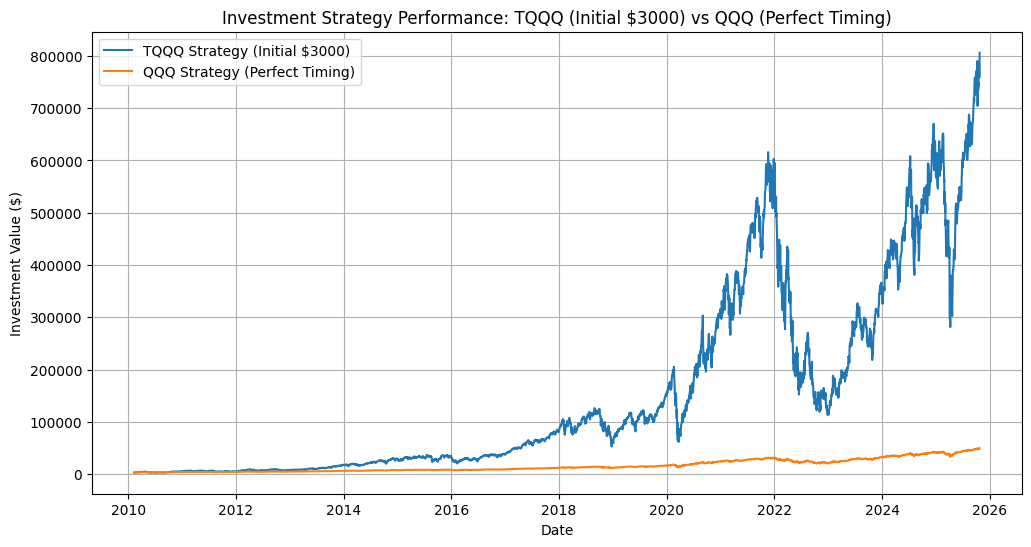

In [150]:
import matplotlib.pyplot as plt

# Plot the investment comparison for the new scenario
plt.figure(figsize=(12, 6))
plt.plot(investment_comparison_new['Date'], investment_comparison_new['TQQQ_Value'], label='TQQQ Strategy (Initial $3000)')
plt.plot(investment_comparison_new['Date'], investment_comparison_new['QQQ_Value'], label='QQQ Strategy (Perfect Timing)')

# Add title and labels
plt.title('Investment Strategy Performance: TQQQ (Initial $3000) vs QQQ (Perfect Timing)')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')

# Add legend and grid
plt.legend()
plt.grid(True)

# Format the y-axis to be in a readable format
plt.ticklabel_format(style='plain', axis='y')

# Show the plot
plt.show()

In [151]:
# Get the last row of the first investment comparison DataFrame
final_values_scenario1 = investment_comparison.iloc[-1]

# Extract the final values for TQQQ and QQQ in the first scenario
final_tqqq_scenario1 = final_values_scenario1['TQQQ_Value']
final_qqq_scenario1 = final_values_scenario1['QQQ_Value']

print(f"Scenario 1 (TQQQ with 10%+ daily drop DCA, QQQ perfect timing):")
print(f"Final TQQQ Value: ${final_tqqq_scenario1:,.2f}")
print(f"Final QQQ Value: ${final_qqq_scenario1:,.2f}")

# Get the last row of the second investment comparison DataFrame
final_values_scenario2 = investment_comparison_new.iloc[-1]

# Extract the final values for TQQQ and QQQ in the second scenario
final_tqqq_scenario2 = final_values_scenario2['TQQQ_Value']
final_qqq_scenario2 = final_values_scenario2['QQQ_Value']

print(f"\nScenario 2 (TQQQ initial $3000, QQQ perfect timing):")
print(f"Final TQQQ Value: ${final_tqqq_scenario2:,.2f}")
print(f"Final QQQ Value: ${final_qqq_scenario2:,.2f}")

Scenario 1 (TQQQ with 10%+ daily drop DCA, QQQ perfect timing):
Final TQQQ Value: $1,743,570.34
Final QQQ Value: $187,732.15

Scenario 2 (TQQQ initial $3000, QQQ perfect timing):
Final TQQQ Value: $806,021.15
Final QQQ Value: $49,428.89
